# Identifying Need for Change: North Carolina School Performance

Out of the 2,617 public schools (including Charter) operating in North Carolina during the 2016-2017 school year, 902 schools (34.5%) have, for at least one year since 2013-2014, been classified as a low performing school. 

NCPDI classifies low performing schools as:

“Low-performing schools are those that receive a **school performance grade** of **D** or **F** and a **school growth score** of **"met expected growth"** or **"not met expected growth"** as defined by G.S. 115C-83.15.” (G.S. 115C-105.37(a)), and

“A Low-performing local school administrative unit is a unit in which the majority of the schools in that unit that received a school performance grade and school growth score as provided in G.S. 115C-83.15 have been identified as low-performing schools, as provided in G.S. 115C-105.37.” (G.S. 115C-105.39A(a)).

Source: http://www.ncpublicschools.org/schooltransformation/low-performing/

**Thus, we treat low performing schools as a proxy for aggregate student educational achievement.**


## Motivation: 
Of the 902 schools low performing between 2013/14 and 2016/17, 209 have been low performing for all schools years (8%), 203 have been low performing for 3 of the schools years (7.8%), 227 have been low performing for 2 schools years (8.7%), and 263 have been low performing once (10%). Another way to look at these numbers is to consider that out of the four school years between 2013/14 and 2016/2017, 24.4% of schools have been recurringly low performing. 

What does this mean in terms of students? 
Out of around the 1.5 million total number of students studying in a public school in the 2016/17 school year, around 460,000 of those students (30%) have had at least a year studying a low performing school. Around 100,000 students (6.8%) in North Carolina study at a school that has been low performing for 4 years. 


## Solution:
This notebook reviews NCPDI North Carolina School Report Card and Statistical Profile data to identify the factors that contribute to low school performance. 

We: 

1. Take a look at the heuristically most common reasons for low school performance: percentage of economically disadvantaged students, student demographics, and school funding to see if these indicators are statistically different in low performing schools. 

2. Identify which EOG and EOC assessments suffer the most for low performing schools. ie. Do all schools perform poorly on 3rd grade EOG reading assessments or are the assessment performances more random?

3. Remove the factors outside of the school adminsitration's control from the dataset to determine which school-level factors are most important in determining low performance by:
    1. Performing Feature Importance using XGBoost. XGBoost is a tree-based gradient-boosting method which minimizes a cost function relative to predicting a target variable. When a node in a decision tree is split, we can calculate the following reduction in impurity, and attribute this reduction to feature involved. When the tree is finished splitting nodes, those features with the largest proportional contribution toward decreasing impurity within nodes can be said to be the most “important.”
    2. Targeting schools that deviate between low performance and non-low performance. For each year, we isolate which schools either became low performing or non-low performing from the previous year. We rank the percent change in each feature, and deem those with the highest change of percentage year to year as potentially influential. 
    3. Finally, reviewing the covariance ranking of our selected features to determine which features likely interact in a parametric model. 
    
4. Test the predictive nature of our selected features by creating a classification model to predict whether or not a school is low performing for each of our 4 years. Whether these features are important will be reflected in the accuracy and precision of the classification model. 

5. Use a new methodology for decision-making. We create a function that will synthesize data based on percent changes in a certain input feature to then be used in our classification model to predict low performance. This will allow us to review, all things being equal, how a change in one or more features may correlate to a change in school performance. 


*Please note: Dataset Creation and Processing can be found: https://github.com/oleeson/NCPDI-Capstone*


# Narrowing of Focus and EDA

The end goal of our project is to identify school factors within administration's control that can be changed to improve the outcome of school performance. With initial exploratory data analysis we decide the following:

1. Remove Charter Schools from the dataset (operated privately)
2. To focus on Elementary and Middle Schools, as these schools are much more likely to be low performing. Improving student outcomes at the Elementary and Middle School level will also set up students for success in High School. 
3. Remove All Test Scores from the dataset, as these are perfect determinants of school performance 


## EDA for Motivation

In [1]:
#import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()

In [2]:
#Change Dir to Import Dataset for EDA 
os.chdir("..")
cwd = os.getcwd()
cwd = cwd + "/DatasetCreation"

In [3]:
#Read in Dataset
#This dataset is all schools (including charter) in 2017
df_EDA = pd.read_csv(cwd+"/PublicSchools17_EDA.csv")

#### Total Impact

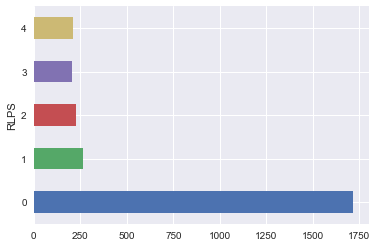

In [4]:
rlpsGroup = df_EDA.groupby(by='RLPS')
rlpsCount = rlpsGroup['RLPS'].count()
numbar17 = rlpsCount.plot(kind='barh')

In [5]:
schoolCount = len(df_EDA)

print("Number of Schools Low Performing...")
print('1 Year : ', rlpsCount[1], "(", round((rlpsCount[1]/schoolCount),3), ")")
print('2 Years: ', rlpsCount[2], "(", round((rlpsCount[2]/schoolCount),3), ")")
print('3 Years: ', rlpsCount[3], "(", round((rlpsCount[3]/schoolCount),3), ")")
print('4 Years: ', rlpsCount[4], "(", round((rlpsCount[4]/schoolCount),3), ")")
print('0 Years: ', rlpsCount[0], "(", round((rlpsCount[0]/schoolCount),3), ")")

print('****************************')
atLeastOnce = (rlpsCount[1] + rlpsCount[2] + rlpsCount[3] + rlpsCount[4])
print('Number of Schools at One Time Low Performing: ', atLeastOnce, "(", round(atLeastOnce/schoolCount,3), ")")

Number of Schools Low Performing...
1 Year :  263 ( 0.1 )
2 Years:  227 ( 0.087 )
3 Years:  203 ( 0.078 )
4 Years:  209 ( 0.08 )
0 Years:  1715 ( 0.655 )
****************************
Number of Schools at One Time Low Performing:  902 ( 0.345 )


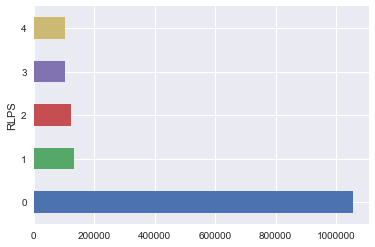

In [6]:
rlpsStud = rlpsGroup['student_num'].sum()
studbar17 = rlpsStud.plot(kind='barh')

In [7]:
studentCount = df_EDA['student_num'].sum()
print('Total Students: ', studentCount)

print('Number of Students in Schools Low Performing...')
print('1 Year : ', rlpsStud[1], "(", round((rlpsStud[1]/studentCount),3), ")")
print('2 Years: ', rlpsStud[2], "(", round((rlpsStud[2]/studentCount),3), ")")
print('3 Years: ', rlpsStud[3], "(", round((rlpsStud[3]/studentCount),3), ")")
print('4 Years: ', rlpsStud[4], "(", round((rlpsStud[4]/studentCount),3), ")")
print('0 Years: ', rlpsStud[0], "(", round((rlpsStud[0]/studentCount),3), ")")

print('****************************')
atLeastOnceStud = (rlpsStud[1] + rlpsStud[2] + rlpsStud[3] + rlpsStud[4])
print('Number of Schools at One Time Low Performing: ', atLeastOnceStud, "(", round(atLeastOnceStud/studentCount,3), ")")

Total Students:  1517530.0
Number of Students in Schools Low Performing...
1 Year :  132901.0 ( 0.088 )
2 Years:  124091.0 ( 0.082 )
3 Years:  101966.0 ( 0.067 )
4 Years:  103128.0 ( 0.068 )
0 Years:  1055444.0 ( 0.696 )
****************************
Number of Schools at One Time Low Performing:  462086.0 ( 0.304 )


#### Schools by Category
- E School has elementary schools grades (PK-5)
- M School has middle schools grades (6-8)
- H School has high schools grades (9-13)
- I School has elementary and middle school grades
- T School has middle and high school grades
- A School has elementary, middle, and high school grades

In [8]:
category = pd.crosstab([ df_EDA['category_cd'] ], 
                       df_EDA['RLPS'])

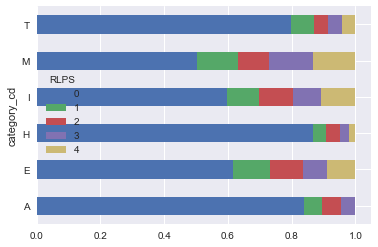

In [9]:
category_rate = category.div(category.sum(1).astype(float),
                             axis=0) # normalize the value

category_rate.plot(kind='barh', 
                   stacked=True)

In [10]:
print (category)

RLPS           0    1    2    3    4
category_cd                         
A             72    5    5    4    0
E            814  155  134  102  117
H            442   21   22   15   10
I             89   15   16   13   16
M            240   62   47   66   63
T             55    5    3    3    3


We see that Middle and Elementary Schools tend to have a higher proportion of total schools low performing.    

In [11]:
mSum = len(df_EDA[df_EDA['category_cd'] == 'M'])
eSum = len(df_EDA[df_EDA['category_cd'] == 'E'])
hSum = len(df_EDA[df_EDA['category_cd'] == 'H'])

mLow = (62+47+66+63)
eLow = (155+134+102+117)
hLow = (21+22+15+10)

print("Percentage of Middle Only Schools at one time Low Performing: ", round(mLow/mSum, 3))
print("Percentage of Elementary Only Schools at one time Low Performing: ", round(eLow/eSum, 3))
print("Percentage of High School Only Schools at one time Low Performing: ", round(hLow/hSum, 3))

Percentage of Middle Only Schools at one time Low Performing:  0.498
Percentage of Elementary Only Schools at one time Low Performing:  0.384
Percentage of High School Only Schools at one time Low Performing:  0.133


#### Look at Charter Schools before Removed

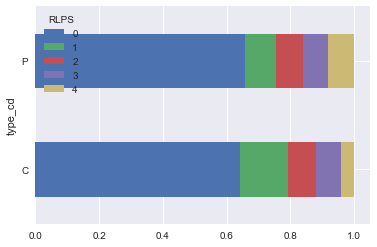

In [12]:
typeSchool = pd.crosstab([ df_EDA['type_cd'] ], 
                       df_EDA['RLPS'])
type_rate = typeSchool.div(typeSchool.sum(1).astype(float),
                             axis=0) # normalize the value

type_rate.plot(kind='barh', 
                   stacked=True)

In [13]:
print(typeSchool)

RLPS        0    1    2    3    4
type_cd                          
C         108   25   15   13    7
P        1607  238  212  190  202


There are 168 total charter schools. From the above bar chart it appears that the pattern of performance is similar to regular public schools. 

## Percent Economically Disadvantaged
Have this just need to move it over

## Racial Demographics
Have this just need to move it over

## Funding
Have this just need to move it over

## Remove Charters and only Include Middle/Elementary Schools in Datasets
The datasets read in with suffix LPS_Processed already do not include charter schools.

In [14]:
## Middle Schools
df_mid_14 = pd.read_csv(cwd+'/2014/PublicMiddleSchools2014_LPS_Processed.csv')
df_mid_14 = pd.read_csv(cwd+'/2014/PublicMiddleSchools2014_LPS_Processed.csv')
df_mid_15 = pd.read_csv(cwd+'/2015/PublicMiddleSchools2015_LPS_Processed.csv')
df_mid_16 = pd.read_csv(cwd+'/2016/PublicMiddleSchools2016_LPS_Processed.csv')
df_mid_17 = pd.read_csv(cwd+'/2017/PublicMiddleSchools2017_LPS_Processed.csv')

## Elementary Schools
df_elem_14 = pd.read_csv(cwd+'/2014/PublicElementarySchools2014_LPS_Processed.csv')
df_elem_15 = pd.read_csv(cwd+'/2015/PublicElementarySchools2015_LPS_Processed.csv')
df_elem_16 = pd.read_csv(cwd+'/2016/PublicElementarySchools2016_LPS_Processed.csv')
df_elem_17 = pd.read_csv(cwd+'/2017/PublicElementarySchools2017_LPS_Processed.csv')

In [15]:
## Column Names
import pickle
cwd = cwd + '/'

fileObject = open(cwd +'2017/TableColumns/ec_pupils_pct_Cols_17.pkl', 'rb')
ec_pupils_pct_Cols_17 = pickle.load(fileObject)

fileObject = open(cwd +'2017/TableColumns/edRatesCols_17.pkl', 'rb')
edRatesCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/effectivenessCols_17.pkl', 'rb')
effectivenessCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/environmentCols_17.pkl', 'rb')
environmentCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/fundingCols_17.pkl', 'rb')
fundingCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/personnelCols_17.pkl', 'rb')
personnelCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/profileCols_17.pkl', 'rb')
profileCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/profileMetricCols_17.pkl', 'rb')
profileMetricCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/pTargets_17.pkl', 'rb')
pTargets_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/readinessCols_17.pkl', 'rb')
readinessCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/sceCols_17.pkl', 'rb')
sceCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/sceCols_17.pkl', 'rb')
sceCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/spgCols_17.pkl', 'rb')
spgCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/yoeCols_17.pkl', 'rb')
yoeCols_17 = pickle.load(fileObject)

In [16]:
# Changing to LPS so it works with the xgboost functions
df_elem_17 = df_elem_17.rename(columns = {'LPS_17' : 'LPS'})
df_mid_17 = df_mid_17.rename(columns = {'LPS_17' : 'LPS'})

# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
combined_cols = (environmentCols_17 + list(set(personnelCols_17) - set(environmentCols_17)))
yoeCols_17 = ['0-3 Years_Exp_Pct_Tch',
            '10+ Years_Exp_Pct_Tch',
            '4-10 Years_Exp_Pct_Tch',
            '0-3 Years_LEA_Exp_Pct_Prin',
            '10+ Years_LEA_Exp_Pct_Prin',
            '4-10 Years_LEA_Exp_Pct_Prin']
for col in yoeCols_17:
    combined_cols.append(col)
combined_cols.append('LPS')

In [17]:
# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_elem_14 = df_elem_14[df_elem_14.columns.intersection(combined_cols)]
df_mid_14 = df_mid_14[df_mid_14.columns.intersection(combined_cols)]
df_elem_15 = df_elem_15[df_elem_15.columns.intersection(combined_cols)]
df_mid_15 = df_mid_15[df_mid_15.columns.intersection(combined_cols)]
df_elem_16 = df_elem_16[df_elem_16.columns.intersection(combined_cols)]
df_mid_16 = df_mid_16[df_mid_16.columns.intersection(combined_cols)]
df_elem_17 = df_elem_17[df_elem_17.columns.intersection(combined_cols)]
df_mid_17 = df_mid_17[df_mid_17.columns.intersection(combined_cols)]

# Storing dfs in list for later iteration
all_datasets = [df_elem_14, df_mid_14,
                df_elem_15, df_mid_15,
                df_elem_16, df_mid_16,
                df_elem_17, df_mid_17]

# Feature Importance Using XGBoost

Data Tables: 
- ec_pupils_pct : Racial Demographics
- edRates : Economically Disadvantaged
- effectiveness: Educator Effectiveness
- environment: Environment
- funding: Funding
- personnel: Personnel
- pTargets : Participation Targets
- Readiness : Readiness
- sce : Specialized Course Enrollment
- schoolInds : School Indicators
- spg : School Performance
- yoe : Years of Experience

http://www.ncpublicschools.org/docs/src/researchers/data-dictionary.pdf

In [18]:
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [19]:
def xg_booster_seat(df, varset='all'):
    '''Performs xgboost on given set of variables, 
        returns feature importances'''
    
    # Subsetting variables if necessary
    if varset == 'all':
        df = df
    else:
        df = df[df.columns.intersection(varset)]
    
    # Predicting LPS
    y = df['LPS']
    x = df.drop('LPS', axis=1)
        
    # Fitting the model
    model = XGBClassifier(nthread=4)
    model.fit(x, y)
   
    # Storing feature importances in dataframe
    feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns)
    
    return feat_importances

col_names = ["df_elem_14_featimp", "df_mid_14_featimp", 
            "df_elem_15_featimp", "df_mid_15_featimp", 
            "df_elem_16_featimp", "df_mid_16_featimp", 
            "df_elem_17_featimp", "df_mid_17_featimp"]

def get_importances(col_names=col_names, varset='all'):
    
    importances = pd.DataFrame()
    for df in all_datasets:
        temp = xg_booster_seat(df, varset=varset)
        importances = pd.concat([importances, temp], axis=1)
    
    importances.columns = col_names
    importances['mean'] = importances.mean(axis=1)
    importances['std'] = importances.std(axis=1)
    
    return importances

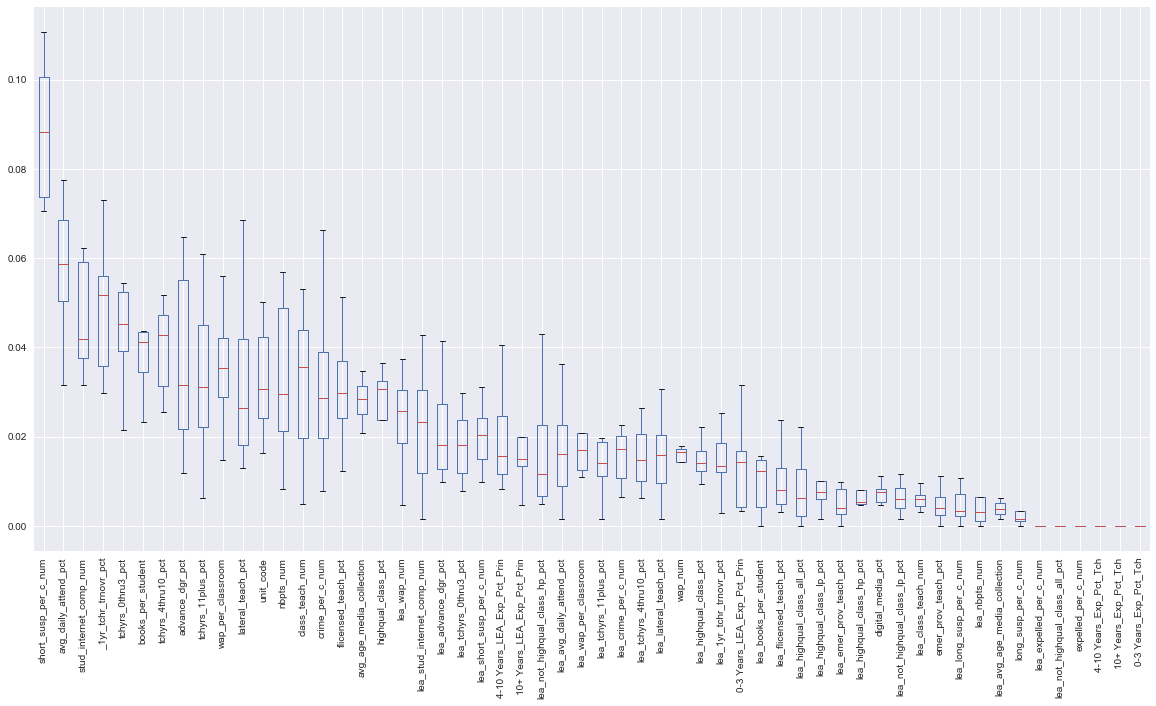

In [20]:
%matplotlib inline
all_importances = get_importances()
all_importances_plots = all_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
all_importances_plots.boxplot(figsize=(20,10), rot=90)

### Environment Variables Only


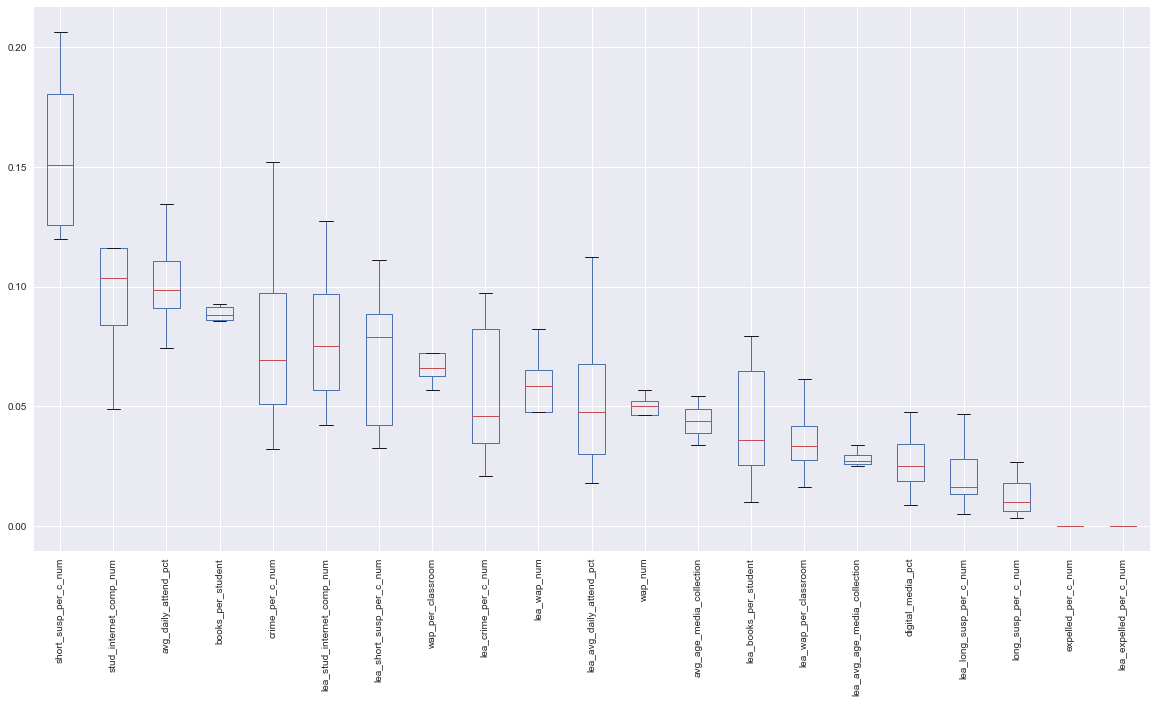

In [21]:
environmentCols_17.append("LPS")
environmentCols_17.remove("unit_code")
environment_importances = get_importances(varset=environmentCols_17)
environment_importances_plots = environment_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
environment_importances_plots.boxplot(figsize=(20,10), rot=90)